# Pyro Crash Course – Minimal Inference Example

This is the first step in the **Atlas optimization Pyro Crash Course**.  
We'll build a simple probabilistic model of noisy data and estimate its parameters using **Stochastic Variational Inference (SVI)**.

---

### 🧠 Learning Goals

- Understand the difference between a *model* and an *inference algorithm*
- Use `pyro.param()` to estimate parameters via optimization
- Perform Maximum Likelihood Estimation (MLE) using SVI
- Visualize the resulting fit and connect to classical ideas


For this, do the following:
   1. Imports and definitions
   2. Generate data
   3. Define stochastic model
   4. Perform inference
   5. Plots and illustrations

```
*This notebook and series are created for educational purposes by Dr. Jemil Avers Butt, Atlas Optimization GmbH – [www.atlasoptimization.com](https://www.atlasoptimization.com).*
```

## 1. Imports and definitions

We import the necessary tools from Pyro, PyTorch, and Matplotlib.

We also fix random seeds to ensure reproducibility. This makes the random sampling and inference deterministic across runs.


In [1]:
"""
    1. Imports and definitions
"""

# i) Imports
import pyro
import torch

import matplotlib.pyplot as plt

# ii) Definitions
n_data = 100
torch.manual_seed(0)
pyro.set_rng_seed(0)


## 2. Generate Data

We generate 100 samples from a standard normal distribution:  
$$
y_i \sim \mathcal{N}(0, 1)
$$

This acts as our ground truth. Later, we will try to **recover** the mean and standard deviation using Pyro.


In [2]:
"""
    2. Generate data
"""

# i) Set up data distribution (=standard normal))
mu_true = torch.zeros([1])
sigma_true = torch.ones([1])

extension_tensor = torch.ones([100])
data_dist = pyro.distributions.Normal(loc = mu_true * extension_tensor, scale = sigma_true)

# ii) Sample from dist to generate data
data = data_dist.sample()


## 3. Define stochastic model

The model represents our **belief** about how data were generated. We assume each observation $ y_i $ was drawn independently from:
$$
y_i \sim \mathcal{N}(\mu, \sigma)
$$

Here, $\mu$ and $\sigma$ are **parameters to be learned** — we treat them as deterministic but unknown. We use `pyro.param()` to register them for optimization.

The `pyro.plate` indicates that observations are **conditionally independent**, which is important for both speed and correctness.


In [3]:
"""
    3. Define stochastic model
"""

# i) Define model as normal with mean and var parameters
def model(observations = None):
    mu = pyro.param(name = 'mu', init_tensor = torch.tensor([5.0])) 
    sigma = pyro.param( name = 'sigma', init_tensor = torch.tensor([5.0]))
    
    obs_dist = pyro.distributions.Normal(loc = mu * extension_tensor, scale = sigma)
    with pyro.plate(name = 'data_plate', size = n_data, dim = -1):
        model_sample = pyro.sample('observation', obs_dist, obs = observations)

    return model_sample


### Guide Function (Empty)

In Pyro, the `guide()` is the variational distribution used to approximate posteriors.

Here, since we're just optimizing parameters (no latent variables), the guide can be empty.  
This makes our inference equivalent to **Maximum Likelihood Estimation**.


In [4]:
# ii) Set up guide
def guide(observations = None):
    pass


## 4. Perform inference

We use Stochastic Variational Inference (SVI) to minimize the **ELBO** —  
the Evidence Lower Bound, which in this case equals the negative log-likelihood.

This optimization finds the values of `mu` and `sigma` that best explain the observed data.

In [5]:
"""
    4. Perform inference
"""

# i) Set up inference
adam = pyro.optim.Adam({"lr": 0.1})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide, adam, elbo)

# ii) Perform svi
loss_sequence = []
for step in range(100):
    loss = svi.step(data)
    loss_sequence.append(loss)
    if step %10 == 0:
        print(f'epoch: {step} ; loss : {loss}')


epoch: 0 ; loss : 304.196533203125
epoch: 10 ; loss : 283.1923828125
epoch: 20 ; loss : 255.5675506591797
epoch: 30 ; loss : 215.86814880371094
epoch: 40 ; loss : 158.92742919921875
epoch: 50 ; loss : 150.34718322753906
epoch: 60 ; loss : 146.04600524902344
epoch: 70 ; loss : 145.4186553955078
epoch: 80 ; loss : 144.3418426513672
epoch: 90 ; loss : 144.4965362548828


## 5. Plots and illustrations

We compare:

- The true values used to generate the data
- The estimated values recovered via Pyro

Then we:

- Plot the ELBO loss during training
- Show a histogram of the observed data
- Compare the **true PDF** with the **inferred PDF**


True mu = tensor([0.]), True sigma = tensor([1.]) 
 Inferred mu = 0.054, Inferred sigma = 1.025


Text(0.5, 1.0, 'True and inferred distributions')

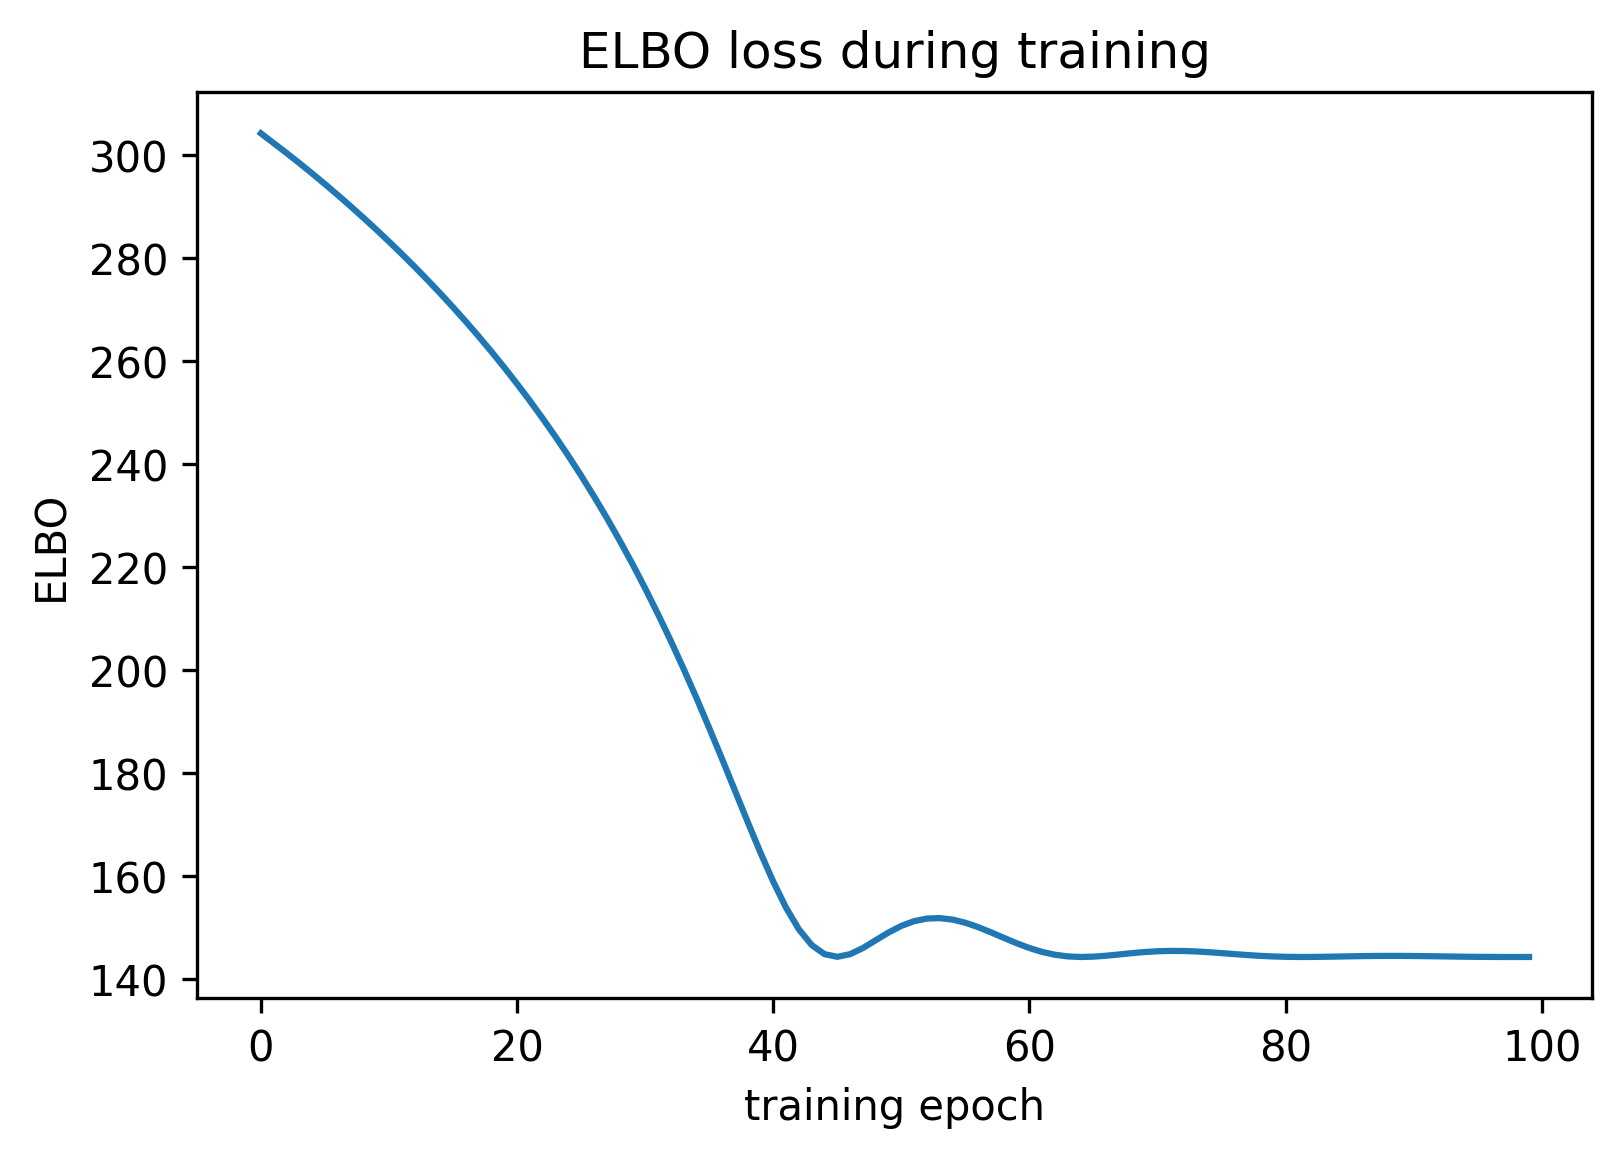

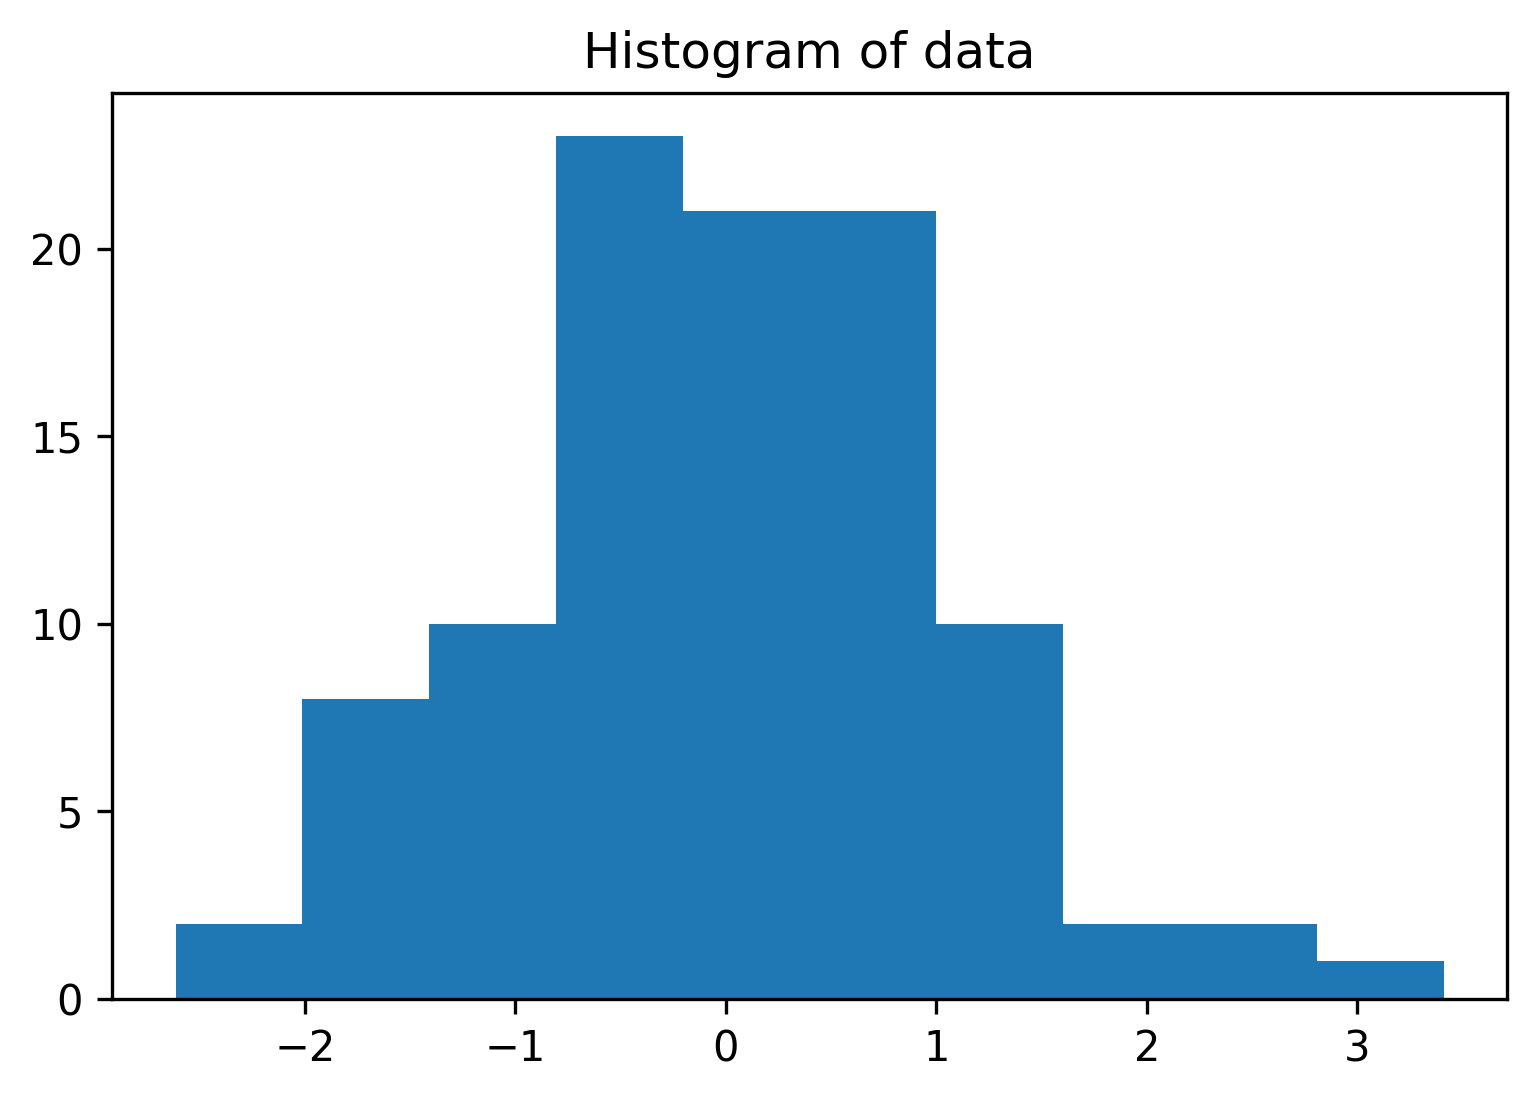

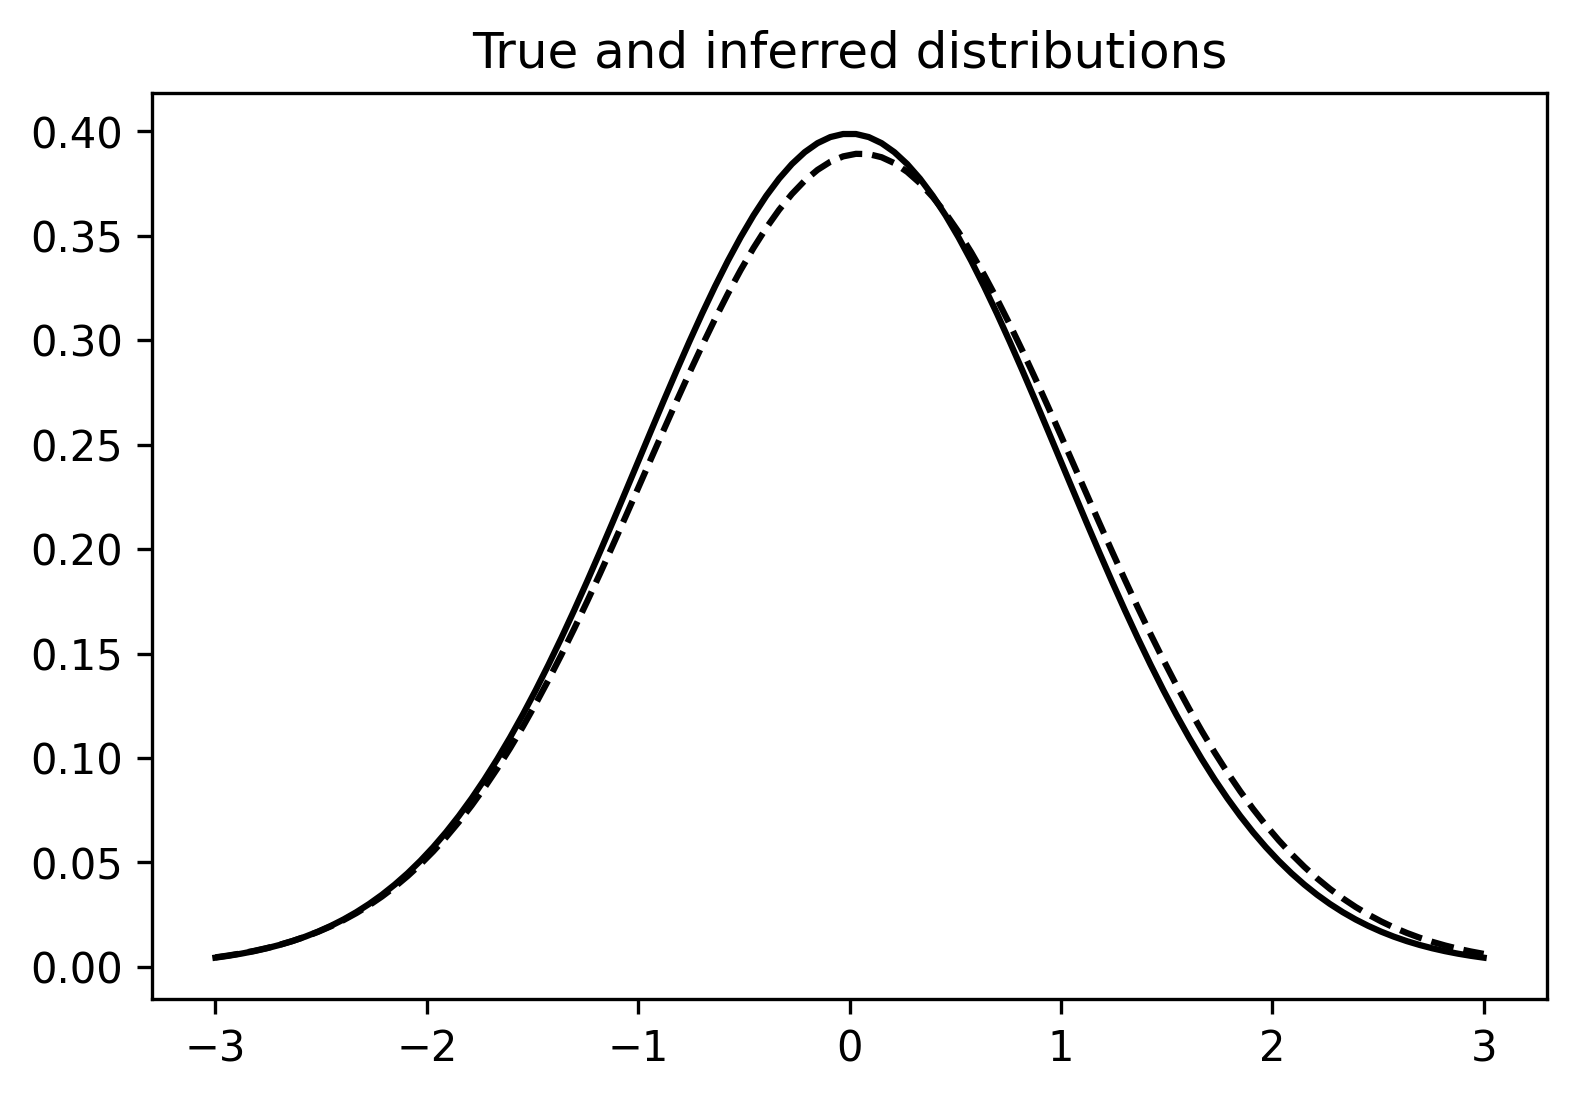

In [6]:
"""
    5. Plots and illustrations
"""

# i) Plot elbo loss
fig1 = plt.figure(num = 1, dpi = 300)
plt.plot(loss_sequence)
plt.title('ELBO loss during training')
plt.ylabel('ELBO')
plt.xlabel('training epoch')

# ii) Print results
print('True mu = {}, True sigma = {} \n Inferred mu = {:.3f}, Inferred sigma = {:.3f}'
      .format(mu_true, sigma_true, 
              pyro.get_param_store()['mu'].item(),
              pyro.get_param_store()['sigma'].item()))

# iii) Plot data
fig1 = plt.figure(num = 2, dpi = 300)
plt.hist(data.detach().numpy())
plt.title('Histogram of data')

# iv) Plot distributions
t = torch.linspace(-3,3,100)
inferred_dist = pyro.distributions.Normal( loc = pyro.get_param_store()['mu'], 
                                          scale = pyro.get_param_store()['sigma'])

fig2 = plt.figure(num = 3, dpi = 300)
plt.plot(t, torch.exp(data_dist.log_prob(t)), color = 'k', label = 'true', linestyle = '-')
plt.plot(t, torch.exp(inferred_dist.log_prob(t)).detach(), color = 'k', label = 'inferred', linestyle = '--')
plt.title('True and inferred distributions')


---

## 🧾 Summary

In this notebook, we:

✅ Defined a simple Gaussian model  
✅ Fit the parameters \(\mu, \sigma\) using SVI  
✅ Performed MLE by using an empty guide  
✅ Visualized the model's fit to synthetic data  

---

📌 In the next notebook, we'll introduce the **thermistor dataset** that will serve as our testing ground for a sequence of models of increasing complexity.
